In [1]:
# helper libraries
import numpy as np
import pandas as pd
import scipy.stats as sci
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# model prep
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
df = pd.read_csv('./PFTResultsDatasetv2.csv')
df.shape

(4783, 79)

In [3]:
"""
      'TestTakenDTS'              # Same as VisitDate except with time. Discarding for now.
    
    , 'HeightInches'              # Information captured in BMI
    , 'WeightLbs'                 # Information captured in BMI
    
    , 'AssumedPatientEncounterID' # ID column. no semantic significance
    , 'PatientID'                 # ID column. no semantic significance
    , 'PAT_DemId'                 # ID column. no semantic significance
    , 'VISITINFO_ID'              # ID column. no semantic significance
    , 'LEVEL_ID'                  # ID column. no semantic significance
    , 'MEAS_Id'                   # ID column. no semantic significance
    , 'SUBMEAS_Id'                # ID column. no semantic significance
    , 'MRN'                       # Patient ID no semantic significance
    
    , 'IsCOPDFLG'                 # This based on the patient's problem list which is unreliable per problem documentation
    , 'PL_IsCOPDFLG'              # patients were mistakenly diagnosed unless given a test
    , 'IsCOPDNBR'
                                  
    , 'PatientEthnicityDSC'       # This is a more granular ethnicity of EthnicityGroupDSC.        
"""

col_exclude = [
      'TestTakenDTS'
    , 'HeightInches'
    , 'WeightLbs'
    , 'AssumedPatientEncounterID'
    , 'PatientID'
    , 'PAT_DemId'
    , 'VISITINFO_ID'
    , 'LEVEL_ID'
    , 'MEAS_Id'
    , 'SUBMEAS_Id'
    , 'MRN'
    , 'IsCOPDFLG'
    , 'PL_IsCOPDFLG'
    , 'IsCOPDNBR'
    , 'PatientEthnicityDSC'
]
# return all columns excluding those listed in the exlcusion list
copd = df.drop(col_exclude, axis=1) # alternate method = df.loc[:, ~df.columns.isin(col_exclude)]

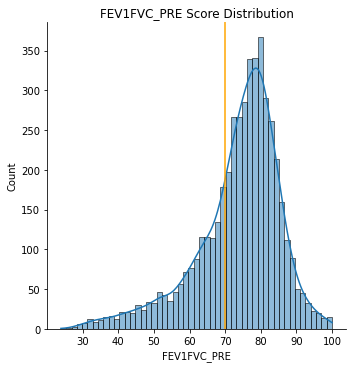

In [4]:
# Scores below 70 are considered to be at risk for COPD. Dataset available is skewed towards the higher end aka people
# who do not have COPD. This means there is more data to predict non-COPD risk patients than COPD risk patients and is something
# to be aware of
sns.displot(copd, x='FEV1FVC_PRE', kde=True)
plt.title('FEV1FVC_PRE Score Distribution')
plt.axvline(70.0, color='orange')

Text(0.5, 1.0, 'IsFEV1FVCUnder70FLG Distribution')

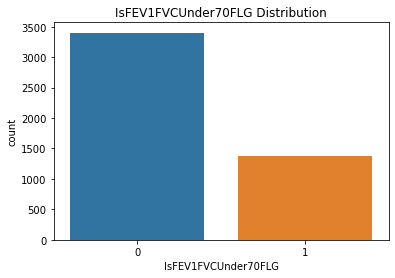

In [5]:
sns.countplot(data=copd, x='IsFEV1FVCUnder70FLG')
plt.title('IsFEV1FVCUnder70FLG Distribution')

In [6]:
# get count of unique values of each column and remove low cardinality columns that would not help with the training
low_cardinality = []

for i in range(copd.shape[1]):
    if copd.iloc[:,i].nunique() < 2:
        low_cardinality.append(copd.columns[i])
        #print(copd.columns[i], ' unique values = ', copd.iloc[:,i].nunique(),'\n')
        
print(low_cardinality)
copd.drop(low_cardinality, axis=1, inplace=True)

['RFV_SleepApneaNBR', 'IsChlamydialInfectionNBR', 'IsChlamydialInfectionFLG']


In [7]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_dia = imputer_mean.fit_transform(copd[['BloodPressureDiastolicNBR']])
imputed_sys = imputer_mean.fit_transform(copd[['BloodPressureSystolicNBR']])
copd['BloodPressureDiastolicNBR'] = imputed_dia
copd['BloodPressureSystolicNBR'] = imputed_sys

In [8]:
# Turn AgeGroupDSC into an ordinal column
age_group_order = {'Age < 18': 0,'Age 18-44': 1, 'Age 45-54': 2, 'Age 55-64': 3, 'Age 65+': 4}
copd['AgeGroupOrdinalNBR'] = copd['AgeGroupDSC'].map(age_group_order)

In [10]:
# OneHot Encode TobaccoUserDSC and EthnicGroupDSC
copd.loc[pd.isna(copd['IsTobaccoUserDSC']), 'IsTobaccoUserDSC'] = 'Unknown Smoker'
ohe = OneHotEncoder(sparse=False)
one_hot = ohe.fit_transform(copd[['IsTobaccoUserDSC', 'EthnicGroupDSC']])

# get columns
encoded_col = np.concatenate((ohe.categories_[0], ohe.categories_[1]), axis=0)

# replace space with underscore
for i in range(len(encoded_col)):
    #print(i, encoded_col[i])
    encoded_col[i] = encoded_col[i].replace(' ', '_')
    
# create new data frame from one hot columns
encoded_df = pd.DataFrame(one_hot, columns=encoded_col)
copd = pd.concat([copd, encoded_df], axis=1)

In [11]:
exclude_from_model_col = ['VisitDate', 'FEV1FVC_PRE', 'IsTobaccoUserDSC', 'EthnicGroupDSC', 'AgeGroupDSC']
copd_base = copd.drop(exclude_from_model_col, axis=1)

In [12]:
# Final set of columns to train on
copd_base.columns

Index(['IsFEV1FVCUnder70FLG', 'IsMaleFLG', 'BMI', 'AgeYearsNBR',
       'PL_IsVascularDiseaseFLG', 'PL_IsValveDisorderFLG', 'PL_IsStrokeFLG',
       'PL_IsCerebrovascularFLG', 'PL_IsObesityFLG', 'PL_IsHypertensionFLG',
       'PL_IsAsthmaFLG', 'PL_IsImmunocompromisedFLG', 'PL_IsHeartFailureFLG',
       'PL_IsHeartDiseaseFLG', 'PL_IsDiabeticFLG', 'IsRecentHomelessFLG',
       'EDVisitsNBR', 'IPVisitsNBR', 'TotalIPDaysNBR', 'TotalReadmitsNBR',
       'BloodPressureDiastolicNBR', 'BloodPressureSystolicNBR',
       'RFV_ChestTightnessNBR', 'RFV_CoughNBR', 'RFV_DyspneaNBR',
       'RFV_FatigueNBR', 'RFV_Mucous_PhlegmNBR', 'RFV_ShortOfBreathNBR',
       'RFV_SleepProblemNBR', 'RFV_HasSymptomsNBR',
       'RFV_HasMultipleSymptomsNBR', 'IsDiabetesMellitusNBR',
       'IsHeartFailureNBR', 'IsUpperRespiratoryNBR', 'IsBronchitisNBR',
       'IsAsthmaNBR', 'IsPneumoniaNBR', 'IsCoughNBR', 'IsDyspneaNBR',
       'IsRespiratorySymptomsNBR', 'IsChestPainNBR', 'IsFatigueNBR',
       'IsSleepDisorderNBR

In [13]:
# create held out test set from data
held_out_test = copd_base.sample(frac=0.1, replace=False, random_state=23)
held_out_testX = held_out_test.drop('IsFEV1FVCUnder70FLG', axis=1)
held_out_testy = held_out_test['IsFEV1FVCUnder70FLG']

In [14]:
held_out_test.shape

(478, 72)

Text(0.5, 1.0, 'IsFEV1FVCUnder70FLG Held Out Test Distribution')

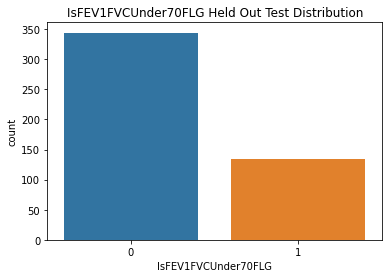

In [15]:
# check distribution of held out test labels contains 1's
sns.countplot(data=pd.DataFrame(held_out_testy, columns=['IsFEV1FVCUnder70FLG']), x='IsFEV1FVCUnder70FLG')
plt.title('IsFEV1FVCUnder70FLG Held Out Test Distribution')

In [16]:
# remove rows that were used in held out test set
copd_base = copd_base.loc[~copd_base.index.isin(held_out_test.index)]
target = copd_base['IsFEV1FVCUnder70FLG']
copd_base.drop(['IsFEV1FVCUnder70FLG'], axis=1, inplace=True)

Text(0.5, 1.0, 'IsFEV1FVCUnder70FLG Training Distribution')

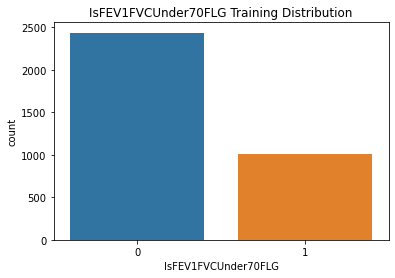

In [17]:
t_size = 0.8

X_train, X_test, y_train, y_test = train_test_split(copd_base, target, train_size=t_size)

rows = round(copd_base.shape[0] * t_size)

assert X_train.shape == (round(copd_base.shape[0] * t_size), 71)
assert X_test.shape == (round(copd_base.shape[0] * (1 - t_size)), 71)
assert y_train.shape == (round(copd_base.shape[0] * t_size),)
assert y_test.shape == (round(copd_base.shape[0] * (1 - t_size)),)

sns.countplot(data=pd.DataFrame(y_train, columns=['IsFEV1FVCUnder70FLG']), x='IsFEV1FVCUnder70FLG')
plt.title('IsFEV1FVCUnder70FLG Training Distribution')

In [18]:
print('X_train shape =', X_train.shape)
print('X_test shape =', X_test.shape)

X_train shape = (3444, 71)
X_test shape = (861, 71)


Text(0.5, 1.0, 'IsFEV1FVCUnder70FLG True Value Distribution')

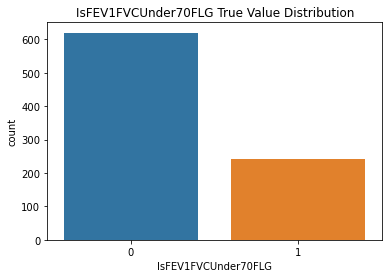

In [19]:
sns.countplot(data=pd.DataFrame(y_test, columns=['IsFEV1FVCUnder70FLG']), x='IsFEV1FVCUnder70FLG')
plt.title('IsFEV1FVCUnder70FLG True Value Distribution')

In [20]:
rfc_search_space = {
      'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    , 'criterion': ['gini', 'entropy']
    , 'min_samples_split': sci.randint(2,20)
    , 'max_depth': sci.randint(2,20)
}

rfc = RandomForestClassifier(random_state=1)

params = {
      'estimator': rfc
    , 'param_distributions': rfc_search_space
    , 'n_iter': 100
    , 'scoring': 'roc_auc'
    , 'n_jobs': -1
    , 'cv': 5
    , 'random_state': 1
}

rfc_rs = RandomizedSearchCV(**params)

rfc_rs.fit(X_train, y_train)
rfc_rs.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 12,
 'n_estimators': 700}

In [22]:
rfc_hyperparameters = {
    'criterion': 'entropy'
    ,'max_depth': 10
    ,'min_samples_split': 12
    ,'n_estimators': 700
    ,'random_state': 1    
}

rfc_opt = RandomForestClassifier(**rfc_hyperparameters)
rfc_opt.fit(X_train, y_train)
rfc_cv_score = cross_val_score(rfc_opt, X_test, y_test, scoring='roc_auc', cv=5)
print('5-fold cross validation mean AUROC score with tuned hyperparameters for RFC =', np.mean(rfc_cv_score))

5-fold cross validation mean AUROC score with tuned hyperparameters for RFC = 0.720303928022822


In [21]:
gbc_search_space = {
      'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    , 'learning_rate': [0.1, 0.01, 0.001, 0.0001, 0.00001]
    , 'subsample': [0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
    , 'min_samples_split': sci.randint(2,20)
    , 'max_depth': sci.randint(2,20)
}

gbc = GradientBoostingClassifier(random_state=1)

params = {
      'estimator': gbc
    , 'param_distributions': gbc_search_space
    , 'n_iter': 100
    , 'scoring': 'roc_auc'
    , 'n_jobs': -1
    , 'cv': 5
    , 'random_state': 1
}

gbc_rs = RandomizedSearchCV(**params)

gbc_rs.fit(X_train, y_train)
gbc_rs.best_params_

{'learning_rate': 0.01,
 'max_depth': 7,
 'min_samples_split': 13,
 'n_estimators': 300,
 'subsample': 0.3}

In [23]:
gbc_hyperparameters = {
     'subsample': 0.3
    ,'n_estimators': 300
    ,'min_samples_split': 13
    ,'max_depth': 7
    ,'learning_rate': 0.01
    ,'random_state':1
}

gbc_opt = GradientBoostingClassifier(**gbc_hyperparameters)
gbc_opt.fit(X_train, y_train)
gbc_cv_score = cross_val_score(gbc_opt, X_test, y_test, scoring='roc_auc', cv=5)
print('5-fold cross validation mean AUROC score with tuned hyperparameters for GBC =', np.mean(gbc_cv_score))

5-fold cross validation mean AUROC score with tuned hyperparameters for GBC = 0.6994733377221856


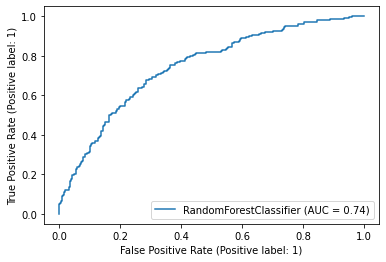

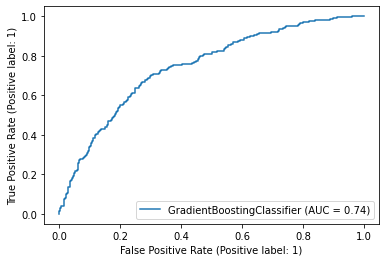

In [53]:
rfc_roc = RocCurveDisplay.from_predictions(y_true=y_test, y_pred=rfc_opt.predict_proba(X_test)[:,1], name='RandomForestClassifier')
gbc_roc = RocCurveDisplay.from_predictions(y_true=y_test, y_pred=gbc_opt.predict_proba(X_test)[:,1], name='GradientBoostingClassifier')
plt.show()

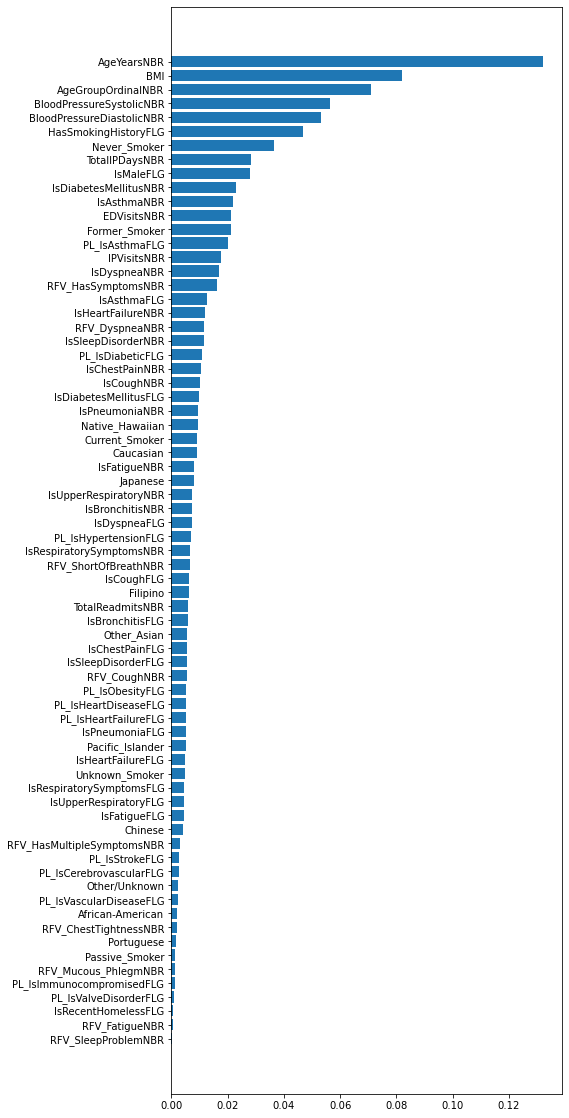

In [44]:
rfc_importances = rfc_opt.feature_importances_
rfc_indices = np.argsort(rfc_importances)
top_features = len(rfc_indices)

fig, ax = plt.subplots(figsize=(7,20))
ax.barh(range(top_features), rfc_importances[rfc_indices])
ax.set_yticks(range(top_features))
_ = ax.set_yticklabels(np.array(X_train.columns)[rfc_indices])

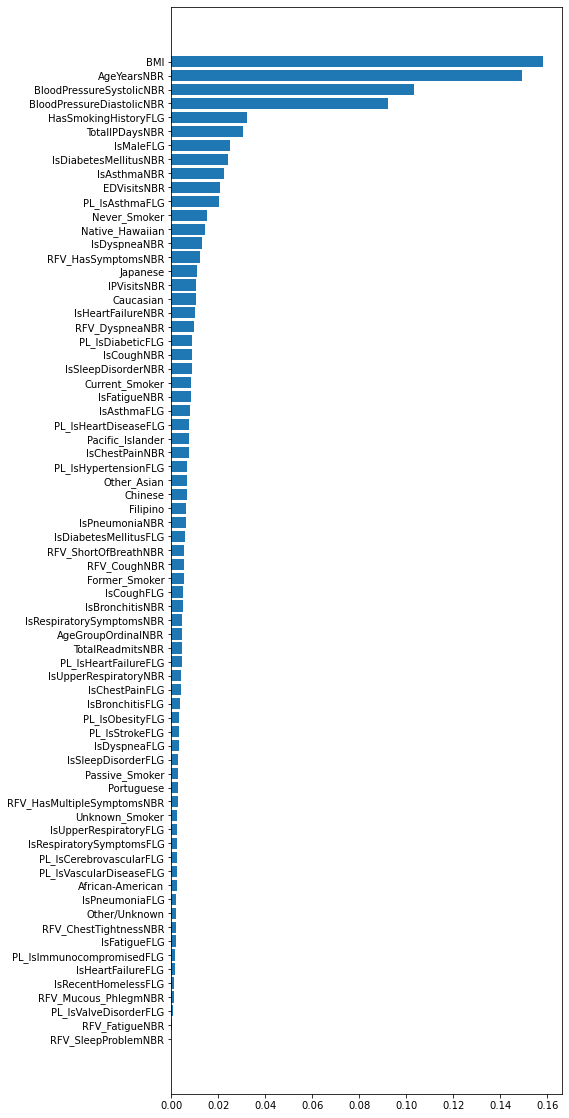

In [27]:
gbc_importances = gbc_opt.feature_importances_
gbc_indices = np.argsort(gbc_importances)

fig, ax = plt.subplots(figsize=(7,20))
ax.barh(range(len(gbc_importances)), gbc_importances[gbc_indices])
ax.set_yticks(range(len(gbc_importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[gbc_indices])

In [57]:
rfc_cv_score = cross_val_score(rfc_opt, held_out_testX, held_out_testy, scoring='roc_auc', cv=5)
gbc_cv_score = cross_val_score(gbc_opt, held_out_testX, held_out_testy, scoring='roc_auc', cv=5)
print('5-fold cross validation mean AUROC score with tuned hyperparameters on held out test set for RFC =', np.mean(rfc_cv_score))
print('5-fold cross validation mean AUROC score with tuned hyperparameters on held out test set for GBC =', np.mean(gbc_cv_score))

5-fold cross validation mean AUROC score with tuned hyperparameters on held out test set for RFC = 0.7016770984375417
5-fold cross validation mean AUROC score with tuned hyperparameters on held out test set for GBC = 0.6833560427763326


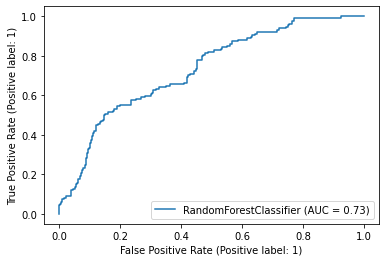

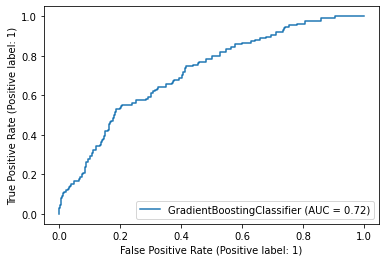

In [24]:
rfc_roc = RocCurveDisplay.from_predictions(y_true=held_out_testy, y_pred=rfc_opt.predict_proba(held_out_testX)[:,1], name='RandomForestClassifier')
gbc_roc = RocCurveDisplay.from_predictions(y_true=held_out_testy, y_pred=gbc_opt.predict_proba(held_out_testX)[:,1], name='GradientBoostingClassifier')
plt.show()

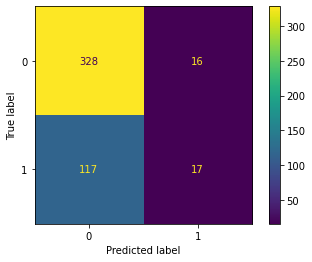

In [55]:
pred = rfc_opt.predict(held_out_testX)
cm = confusion_matrix(y_true=held_out_testy, y_pred=pred, labels=rfc_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_opt.classes_)
disp.plot()
plt.show()

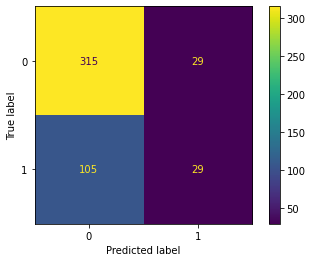

In [56]:
pred = gbc_opt.predict(held_out_testX)
cm = confusion_matrix(y_true=held_out_testy, y_pred=pred, labels=gbc_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc_opt.classes_)
disp.plot()
plt.show()

In [54]:
# predict probabilities using held-out test set
rfc_cpod_true_pred = rfc_opt.predict_proba(held_out_testX)
gbc_cpod_true_pred = gbc_opt.predict_proba(held_out_testX)

highest_copd_true_pred_rfc = np.argmax(rfc_cpod_true_pred[:,1])
highest_copd_true_pred_gbc = np.argmax(gbc_cpod_true_pred[:,1])
print('Random Forest highest probability index =', highest_copd_true_pred_rfc, rfc_cpod_true_pred[highest_copd_true_pred_rfc, :])
print('Gradient Boosted highest probability index =', highest_copd_true_pred_gbc, rfc_cpod_true_pred[highest_copd_true_pred_gbc, :])

Random Forest highest probability index = 477 [0.29420431 0.70579569]
Gradient Boosted highest probability index = 470 [0.33830106 0.66169894]


In [48]:
# create a new column that has the original index in the COPD data set
held_out_test.reset_index(inplace=True)
held_out_test = held_out_test.rename(columns = {'index':'OriginalIndex'})

In [ ]:
# Prints out a dataframe of the held out data set using the highest probability from the argmax to get
# the original index from imported dataframe. Output cleared to protect health information.
held_out_test

In [ ]:
# Original index from imported dataframe shows this person had a FEV1/FVC ratio of 0.6689 using random forest
# Output cleared to protect health information.
copd.iloc[1049]

In [ ]:
# Original index from imported dataframe shows this person had a FEV1/FVC ratio of 0.4957 using gradient boosting
# Output cleared to protect health information.
copd.iloc[int(held_out_test.iloc[470][0])]